In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Conv2DTranspose, BatchNormalization
import numpy as np
import tensorflow_datasets as tfds

#tf.debugging.set_log_device_placement(True)


(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1)) 

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [3]:
batch_size = 32
buffer_size = 10000
train_ds = tf.data.Dataset.from_tensor_slices((x_train, x_train_noisy)).shuffle(buffer_size).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, x_test_noisy)).shuffle(buffer_size).batch(batch_size)


In [4]:
  
class DenoiserBig(Model): 
    """
    Autoencoder model for MNIST imege denoising.
    """
    def __init__(self):
        """
        Initializes autoencoder layers.
        """
        super(DenoiserBig, self).__init__()
        self.encoder_l1 = keras.Sequential((
                            Conv2D(32, 3, padding='same', activation='relu'),
                            BatchNormalization(momentum=0.1, epsilon=1e-5),
                            Conv2D(32, 3, padding='same', activation='relu'),
                            BatchNormalization(momentum=0.1, epsilon=1e-5),
                            Conv2D(64, 3, padding='same', activation='relu'),
                            BatchNormalization(momentum=0.1, epsilon=1e-5),
                            Conv2D(64, 3, padding='same', activation='relu'),
                            BatchNormalization(momentum=0.1, epsilon=1e-5),
                            MaxPool2D()
        ))
        self.encoder_l2 = keras.Sequential((
                            Conv2D(128, 3, padding='same', activation='relu'),
                            BatchNormalization(momentum=0.1, epsilon=1e-5),
                            Conv2D(128, 3, padding='same', activation='relu'),
                            BatchNormalization(momentum=0.1, epsilon=1e-5),
                            MaxPool2D(),
                            Conv2D(256, 3, padding='same', activation='relu')
        ))
        self.decoder_l1 = keras.Sequential((
                            Conv2DTranspose(128, 3, 2, 'same', 1, activation='relu'),
                            BatchNormalization(momentum=0.1, epsilon=1e-5),
                            Conv2DTranspose(128, 3, 1, 'same', activation='relu'),
                            BatchNormalization(momentum=0.1, epsilon=1e-5),
                            Conv2DTranspose(64, 3, 1, 'same', activation='relu'),
                            BatchNormalization(momentum=0.1, epsilon=1e-5),
                            Conv2DTranspose(64, 3, 1, 'same', activation='relu'),
                            BatchNormalization(momentum=0.1, epsilon=1e-5)
        ))
        self.decoder_l2 = keras.Sequential((
                            Conv2DTranspose(64, 3, 1, 'same', activation='relu'),
                            BatchNormalization(momentum=0.1, epsilon=1e-5),
                            Conv2DTranspose(32, 3, 1, 'same', activation='relu'),
                            BatchNormalization(momentum=0.1, epsilon=1e-5),
                            Conv2DTranspose(1, 3, 2, 'same', 1, activation='relu'),
        ))
        
    def call(self, x):
        """
        Defines the computation performed at every call.           
        :param x: Batch of images.
        :return: Image after autoencoder.
        """
        out = self.encoder_l1(x)
        out = self.encoder_l2(out)
        out = self.decoder_l1(out)
        out = self.decoder_l2(out)
        return out

In [5]:
# Init model and training params.
model = DenoiserBig()
loss_object = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.0001)


train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.Mean(name='test_accuracy')

In [7]:
# Test and train step logic.
@tf.function
def train_step(images, images_noised):
    
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(images_noised, training=True)
        loss = loss_object(images, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(images, predictions)
    

@tf.function
def test_step(images, images_noised):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images_noised, training=False)
    t_loss = loss_object(images, predictions)

    test_loss(t_loss)
    test_accuracy(images, predictions)

In [8]:
EPOCHS = 9
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, images_noised in train_ds:
        train_step(images, images_noised)

    for test_images, test_images_noised in test_ds:
        test_step(test_images, test_images_noised)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch+1,
                        train_loss.result(),
                        train_accuracy.result()*100,
                        test_loss.result(),
                        test_accuracy.result()*100))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.0194845050573349, Accuracy: 72.09822082519531, Test Loss: 0.012242352589964867, Test Accuracy: 77.12615203857422
Epoch 2, Loss: 0.011657783761620522, Accuracy: 77.83006286621094, Test Loss: 0.010812736116349697, Test Accuracy: 78.94035339355469
Epoch 3, Loss: 0.01066642627120018, Accuracy: 78.63948059082031, Test Loss: 0.0106338020414114, Test Accuracy: 78.00273132324219
Epoch 4, Loss: 0.010100280866026878, Accuracy: 79.06879425048828, Test Loss: 0.009927671402692795, Test Accuracy: 80.

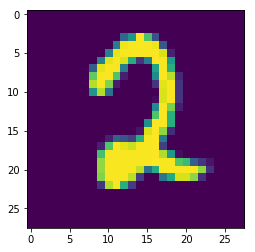

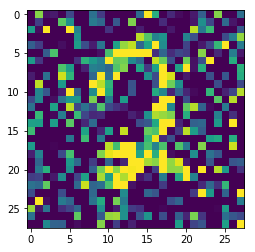

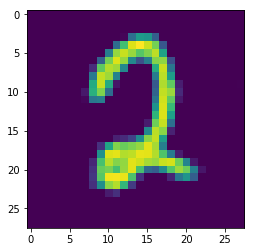

In [21]:
%matplotlib inline
from matplotlib import pyplot as plt

x1, y1 = None, None
for x, y in train_ds:
    x1 = x
    y1 = y
    break

i = 3
x = y1[i]
x = x[tf.newaxis, ...]
out = model(x, training=False)
plt.imshow(x1[i].numpy().reshape((28,28)))
plt.show()
plt.imshow(y1[i].numpy().reshape((28,28)))
plt.show()
plt.imshow(out.numpy().reshape((28,28)))
plt.show()